# Compact Proofs of Model Performance via Mechanistic Interpretability

## 0. Set up (Don't read)

In [3]:
%pip install tqdm
%pip install torch
%pip install einops
%pip install matplotlib
%pip install jaxtyping

Python(79415) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Python(79477) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Python(79522) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Python(79554) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Python(79588) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [18]:
import torch as t
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import time
import einops
from torch.utils.data import Dataset, DataLoader
import random, numpy
from dataclasses import dataclass
from jaxtyping import Float, Int
from torch import Tensor
from typing import Optional, Callable, Union, List, Tuple
import copy
from tqdm import tqdm
from IPython.display import Image, Markdown

In [5]:
@dataclass
class Parameters:
    n_ctx: int = 2
    d_vocab: int = 2048
    d_model: int = 128
    num_epoch: int = 2
    batch_size: int = 1024
    subset_percentage: float = 5
    lr: float = 0.001


params = Parameters()

In [6]:
def set_seed(seed: int = 57) -> None:
    numpy.random.seed(seed)
    random.seed(seed)
    t.manual_seed(seed)
    t.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    t.backends.cudnn.deterministic = True
    t.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)

In [7]:
def measure_time(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Function '{func.__name__}' executed in: {elapsed_time:.6f} seconds")
        return result, elapsed_time

    return wrapper

In [9]:
class TrainingDataMax(Dataset):
    def __init__(self, params):
        set_seed(57)
        self.n = params.d_vocab
        self.n_ctx = params.n_ctx

    def __getitem__(self, idx):

        inputs = [random.randint(0, self.n - 1) for i in range(self.n_ctx)]
        return inputs + [max(inputs)]

    def __len__(self):
        return self.n**self.n_ctx


# set seed -> random select in gettitem

In [10]:
def test_dataset(dataset):
    """
    Function to test a PyTorch Dataset.

    Parameters:
    - dataset (torch.utils.data.Dataset): The dataset to be tested.
    - batch_size (int): Number of samples per batch to load.
    - num_workers (int): How many subprocesses to use for data loading.

    Returns:
    None. Prints information about the batches.
    """

    print("Train data defined")
    dataloader = DataLoader(dataset=dataset, batch_size=params.batch_size, shuffle=True)
    print("Data loaded")

    print(f"Testing {dataset.__class__.__name__} with {len(dataset)} samples...")

    for i_batch, sample_batched in enumerate(dataloader):
        print(f"Batch {i_batch + 1}")

        # Print shapes or other relevant info about each element in sample_batched
        for x in sample_batched:
            print(x)

In [11]:
train_data = TrainingDataMax(params=Parameters)
# test_dataset(train_data)

## 1. Introduction

### 1.1 The problem of understanding a model

**Why do we care about about understanding a model?**

When we use or train a model, many things can go wrong. For example, during training the model can learn undesired behaviour, which is not obvious to us (deceptive alignment). Or it might have failure modes that are not salient to us (adversarial examples). 
On the other hand, we could steer a model towards a desired behaviour, if we understood how it works.

All of these issues could be resolved, if the models were transparent to us (though this is not the only approach). So an important question to raise here is: 
What do we mean when we talk of "a mechanistic understanding" of a model? When is a model transparent to us?

This is a difficult question! Let's say you study a model and reverse engineered parts of it, like a circuit. How can you be sure that the circuit you found actually does the thing you are claiming it is? Let's look at the specific example of autoencoders. This is a quote from [*Towards Monosemanticity: Decomposing Language Models With Dictionary Learning*](https://transformer-circuits.pub/2023/monosemantic-features)

>Usually in machine learning we can quite easily tell if a method is working by looking at an easily-measured quantity like the test loss. We spent quite some time searching for an equivalent metric to guide our efforts here, and unfortunately have yet to find anything satisfactory.
>
>We began by looking for an information-based metric, so that we could say in some sense that the best factorization is the one that minimizes the total information of the autoencoder and the data. Unfortunately, this total information did not generally correlate with subjective feature interpretability or activation sparsity.[...]
>
>Thus we ended up using a combination of several additional metrics to guide our investigations[...]
>
>Interpreting or measuring some of these signals can be difficult, though. For instance, at various points we thought we saw features which at first didn’t make any sense, but with deeper inspection we could understand.
>
>We think it would be very helpful if we could identify better metrics for dictionary learning solutions from sparse autoencoders trained on transformers.

See also Section 5 of this review [*Mechanistic Interpretability for AI Safety -- A Review*](https://arxiv.org/abs/2404.14082) for more references on the difficulty of evaluating interpretability results.

**Quantative methods for interpretability**

Having quantative methods would not only make mechanistic interpretability research more rigorous. If we want to scale up methods to huge models, we will need to automate parts of the process and we won't be able to have a human in the loop at every crucial point. A lack of quantative benchmarks makes this task seem almost impossible. To spoiler the punchline: Compact proofs provide such a quantative benchmark, although they currently are infeasible for larger models.

Before getting into the details, let's nail down two things that we want to quantify. The following two points are taken from the [Compact proofs blog post](https://www.alignmentforum.org/posts/bRsKimQcPTX3tNNJZ/compact-proofs-of-model-performance-via-mechanistic#Introduction), see also this [comment](https://www.lesswrong.com/posts/LNA8mubrByG7SFacm/against-almost-every-theory-of-impact-of-interpretability-1?commentId=7fNRMke9Gc4QghYyf) by Ryan Greenblatt.

>1. Correspondence (or faithfulness): How well our explanation reflects the model's internals.
>2. Compression: Explanations compress the particular behavior of interest. Not just so that it fits in our heads, but also so that it generalizes well and is feasible to find and check.

Specifically, the second points implies that the explanation, say the circuit that we discovered, should be more **compact** and therefore more understandable for us humans: The weights of a model are a perfectly faithful explanation of its behaviour, but this explanation is not helpful for us.

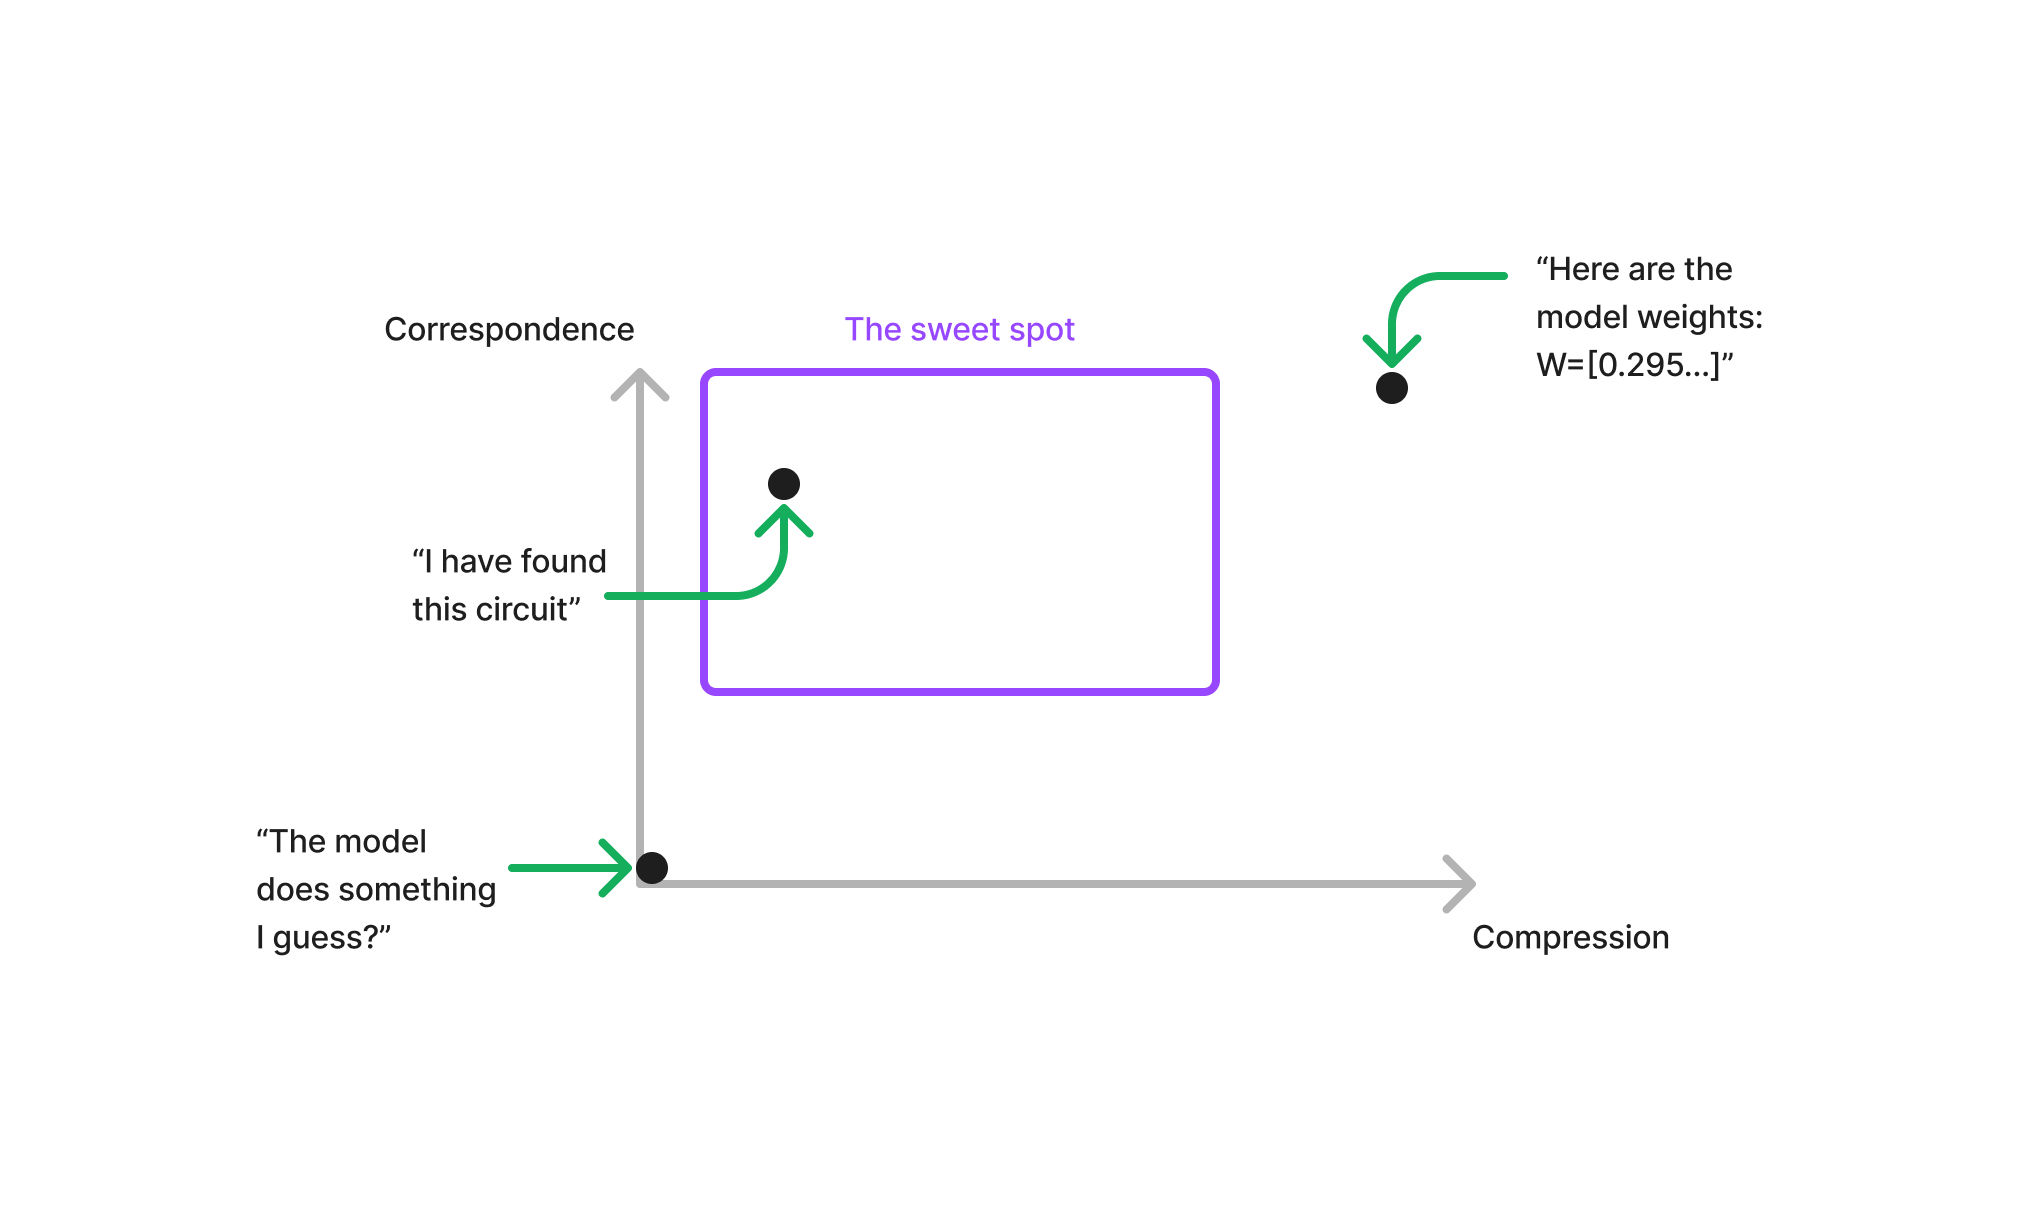

In [12]:
Image(filename="img/Compact proofs.png", width=800, height=400)
# Make this rather a pareto frontier?

An important insight that we will make is that our explanations are not as good as we might think. Specifically, **noise** in the model's weights seem negligible. But worst case bound imply that it could still be an important contribuiting factor. In fact, it might be that something that we deem as noise, is important for the model's computation, but we simply don't understand it. This issue with the noise is another point that a quantative evaluation should be able to address.

### 1.2 **What are compact proofs?**

- proofs of bounds
- graph of compact proofs
- 

## 2. Max-of-2 Example

Having worked through the very high level picture, let us now focus on the compact proofs approach and explain what it means. Let's say we have a model:

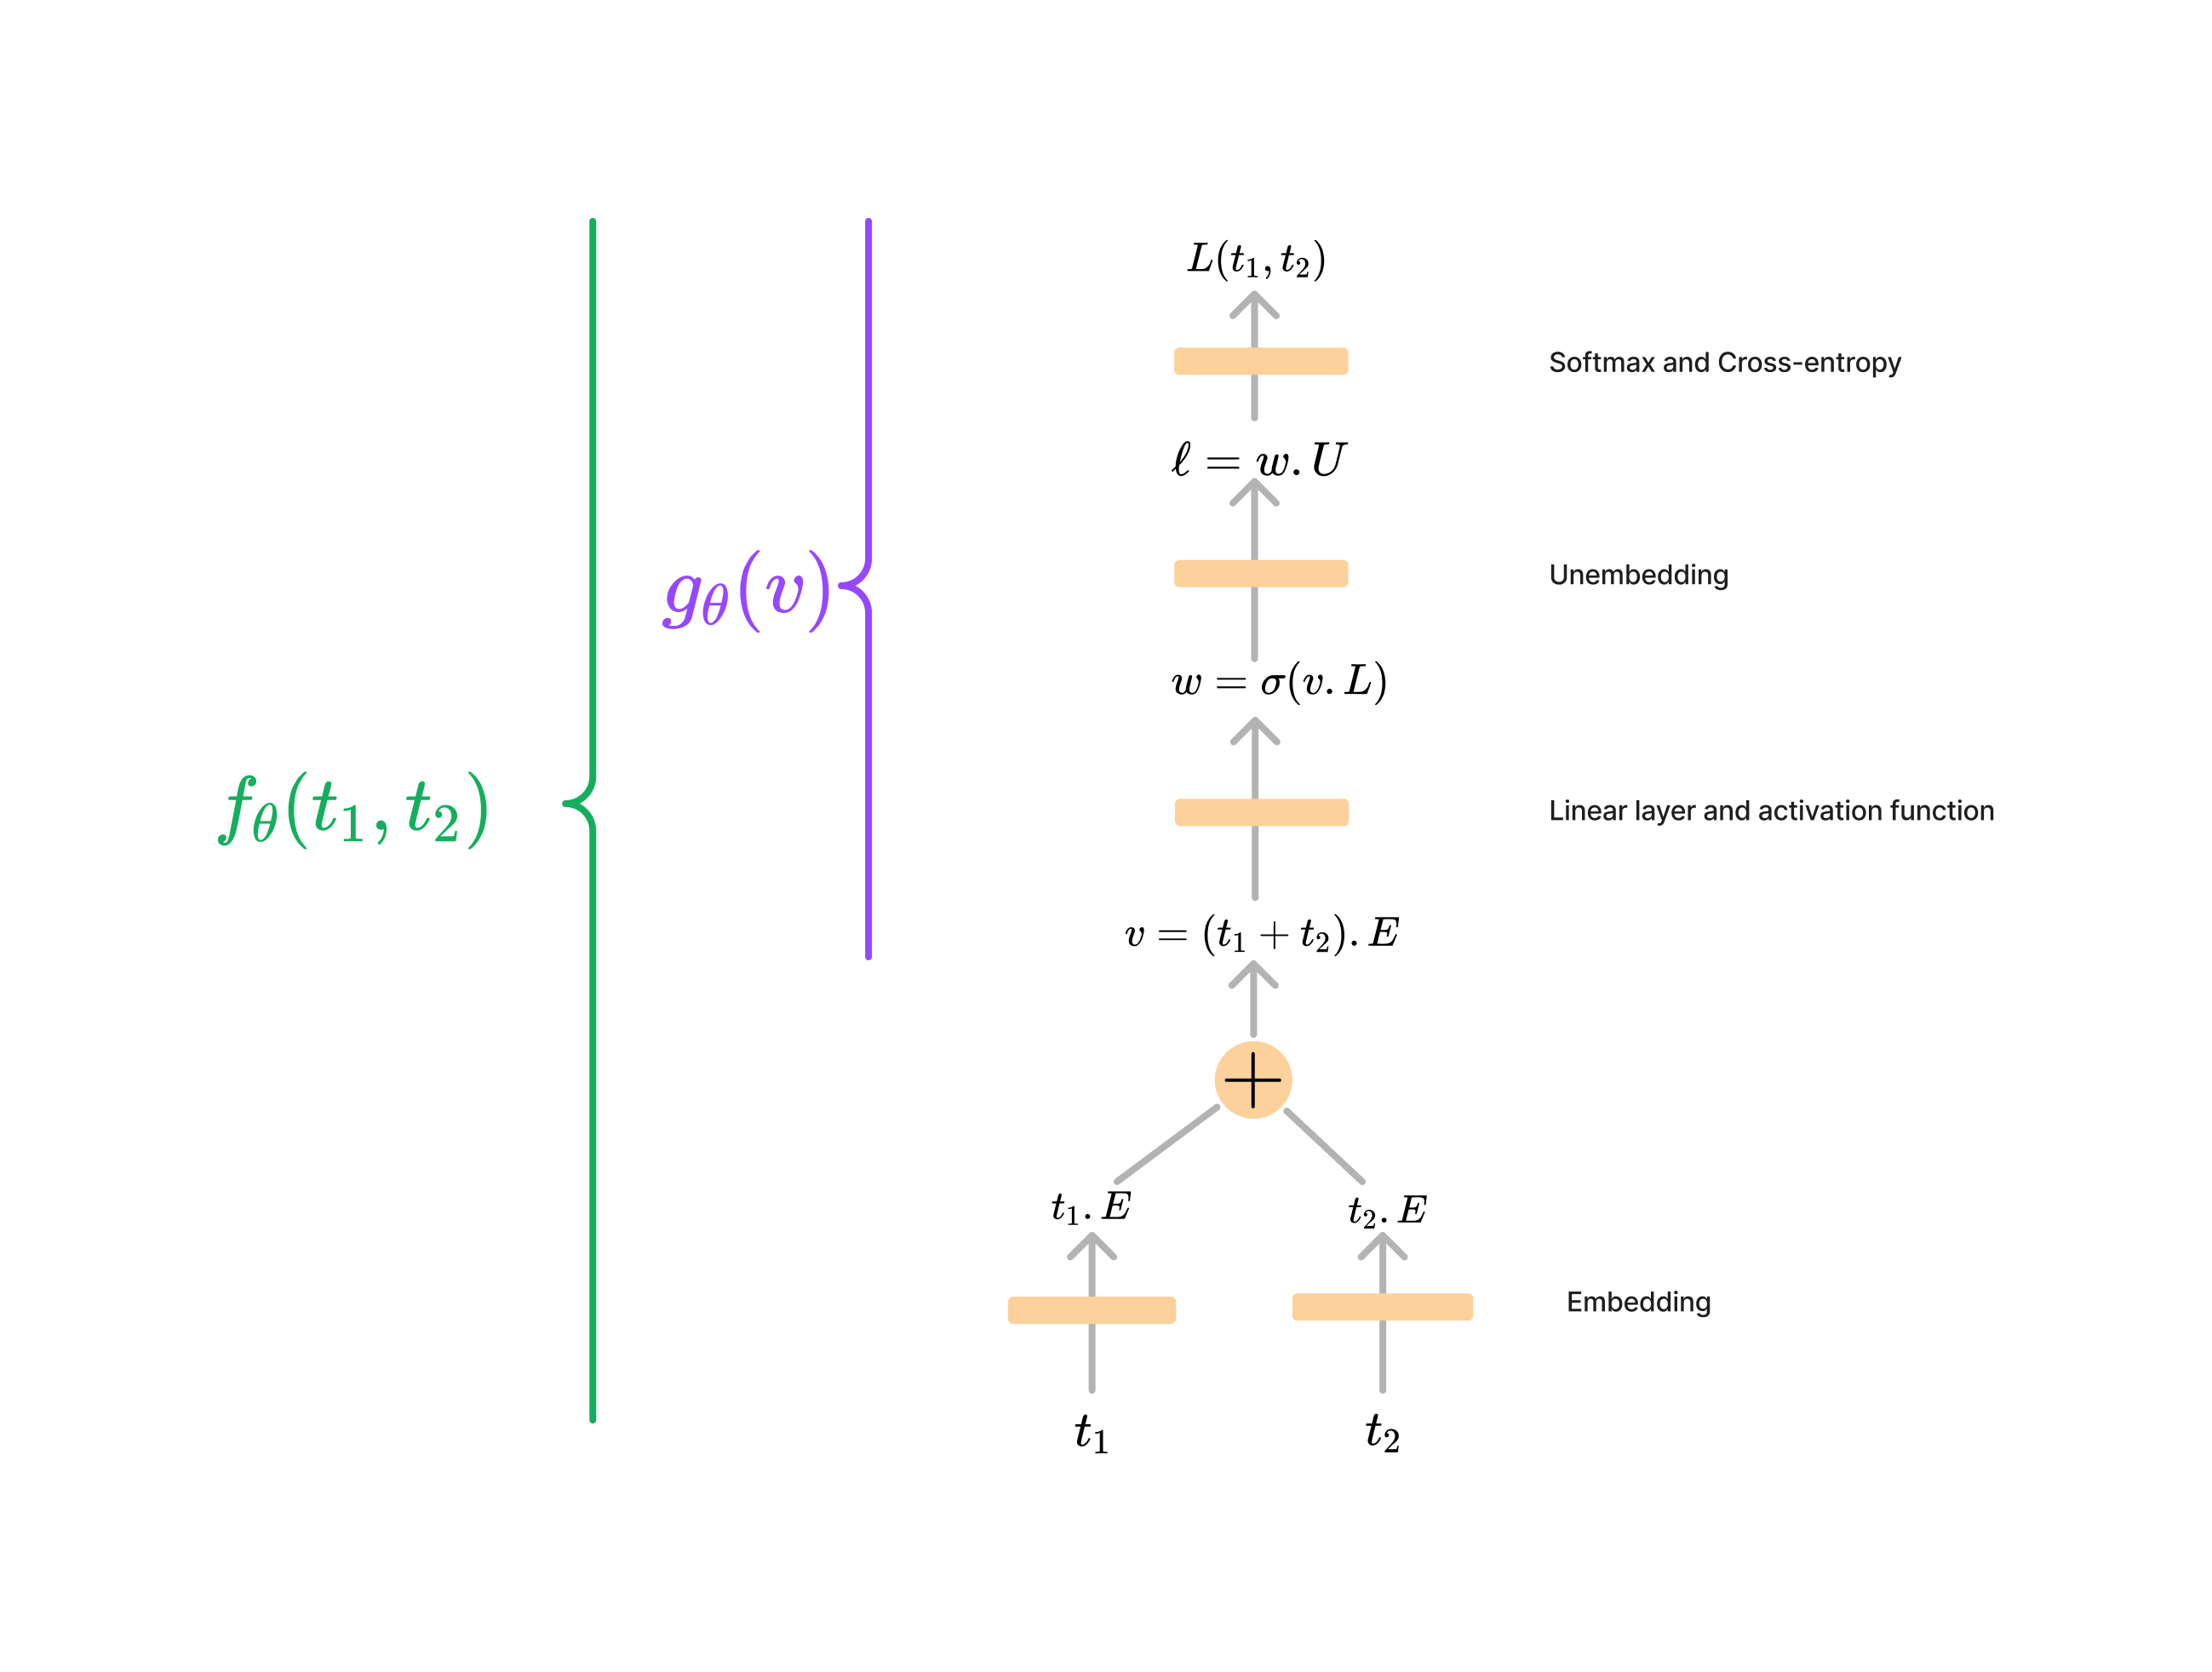

In [23]:
Image(filename="img/Model_2.png", height="700", width="700")

In [14]:
class MLP(t.nn.Module):
    def __init__(self, params):
        super().__init__()
        self.n_ctx = params.n_ctx

        self.embedding = t.nn.Linear(params.d_vocab, params.d_model, bias=False)
        self.linear = t.nn.Linear(params.d_model, params.d_model, bias=False)
        self.activation = t.nn.ReLU()
        self.unembedding = t.nn.Linear(params.d_model, params.d_vocab, bias=False)

    def g(self, x):

        return self.unembedding(self.activation(self.linear(x)))

    def forward(self, a):

        return self.g(self.embedding(a.sum(dim=1)))

In our first example, we will train the model to predict the max of the two tokens, where the tokens range from 0 to **{{ x}}**. We will be interested in estimating the global loss of this model, that is we want to estimate 
$$ \mathbb{E}[f(t_1,t_2)]= \frac{1}{256^2}\cdot\sum_{t_1,t_2\in \{0,...,255\}} f(t_1,t_2). $$
In general, we could replace the loss function by anything measurable that is of interest to us e.g. the accuracy. So generally, we want to **prove** a statement of the form
$$ \mathbb{E}[h(x,M(x))]\leq b $$
where we lower bound (or depending on $f$, upper bound) where $b$ is a specific bound that we compute.

The general proof strategy consists of two steps:
1. P1: Prove a statement that given a model with its weights $W$, there is a quantity $C(W)$ such that $ \mathbb{E}[h(x,M(x))]\leq C(W) $.
2. P2: Compute the quantity $C(W)$.

We will come back to this after we did some proofs and also discuss what it means to have a **compact** proof.

In [14]:
model = MLP(params=Parameters)

In [15]:
def training_step(
    model,
    optimizer,
    batch: Tuple[
        Int[Tensor, "batch_size"], Int[Tensor, "batch_size"], Int[Tensor, "batch_size"]
    ],
    params: Parameters,
):

    criterion = t.nn.CrossEntropyLoss()

    inputs, labels = t.stack(batch[:-1], dim=1), batch[-1]

    inputs_one_hot = F.one_hot(inputs, params.d_vocab).float()

    outputs = model(inputs_one_hot)

    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss

In [16]:
def train(model, params):

    loss_history = []

    subset_cardinality = int(
        len(TrainingDataMax(params=Parameters)) * (params.subset_percentage / 100)
    )
    remaining_cardinality = len(TrainingDataMax(params=params)) - subset_cardinality

    print("Loading data...")
    train_data, _ = t.utils.data.random_split(
        TrainingDataMax(params=params), [subset_cardinality, remaining_cardinality]
    )
    print("Train data defined")
    dataloader = DataLoader(train_data, batch_size=params.batch_size, shuffle=True)
    print("Data loaded")

    optimizer = t.optim.AdamW(
        model.parameters(),
        lr=params.lr,
    )

    for epoch in range(params.num_epoch):
        print(epoch)
        for i, batch in enumerate(dataloader):
            loss = training_step(
                model=model, optimizer=optimizer, batch=batch, params=params
            )

            loss_history.append(loss.detach().item())

    return loss_history

We train our model on ~$10\%$ of the whole data set.
(This is not correct, dataset is random each batch)

In [17]:
model = MLP(params=params)
loss_history = train(model=model, params=params)

Loading data...
Train data defined
Data loaded
0
1


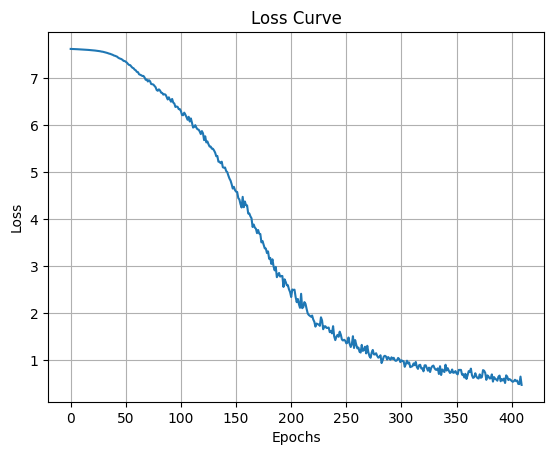

In [19]:
plt.plot(loss_history)
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

Note that this is our **training set** loss.

In [20]:
loss_history[-5:]

[0.5607976913452148,
 0.4883713126182556,
 0.48504024744033813,
 0.6442803144454956,
 0.4672522246837616]

### 2.1 Brute force proof

Let's start proving things now! One thing we can do is a brute force proof. Remember that our proofs will consist of two steps. The first step (P1) is as follows

Theorem(Brute force proof):
The expected loss of a model $M$ with weights $\theta$ is bounded above by $\mathbb{E}[f(t_1,t_2)]$.

Proof: By definition the bound is actually an equality.

That was an easy proof, but the ones we will encounter from now on will be more difficult and feel less tautological!
Now we come to the second part of the proof (P2), which in this case means computing this quantity.

In [1]:
performance = []

In [21]:
def brute_force_loss(model, params: Parameters) -> Float:
    """Computes the loss for every possible input and returns the average of the sum of the losses"""

    loss = 0
    criterion = t.nn.CrossEntropyLoss()

    # Solution goes here

    pass

In [2]:
@measure_time
def brute_force_loss_proof(model, params):
    loss = 0
    criterion = t.nn.CrossEntropyLoss()

    with t.no_grad():
        model.eval()

        for x in tqdm(range(0, params.d_vocab)):

            x_tensor = t.tensor([x] * (params.d_vocab))
            y_tensor = t.tensor([i for i in range(params.d_vocab)])

            labels = t.max(x_tensor, y_tensor)

            inputs = t.stack(
                [
                    F.one_hot(x_tensor, num_classes=params.d_vocab).float(),
                    F.one_hot(y_tensor, num_classes=params.d_vocab).float(),
                ],
                dim=1,
            )

            outputs = model(inputs)

            loss += criterion(outputs, labels)

    return loss / params.d_vocab

NameError: name 'measure_time' is not defined

In [ ]:
loss_bf, time_bf = brute_force_loss_proof(model=model, params=params)

In [121]:
performance.append((loss_bf, time_bf))

<details>
  <summary>A word on the "formal" in "formal proofs".</summary>
  
  Strictly speaking we would want to formalize our proofs, meaning that we would rewrite them in a form that can be verified by a formal proof assistant such as Lean or Coq. For a more serious use case this would be indeed necessary, but for now I will leave it open to the you, the reader, to formalize the proof that you would want to be verified. Generally speaking, be aware though that Lean and Coq also have bugs!
  
</details>

### 2.2 Symmetry proof

Our brute force proof gave the optimal bound, but at the cost of having to compute all the inputs. 
Can we do better? Yes!

We start with the first part P1 of our proof. It will be based on the following observation

Lemma: Let $f_\theta(t_1,t_2)$ denote the neural network as depicted above. Then $$ f_\theta(t_1,t_2) = f_\theta(t_2,t_1).$$

Try to prove that statement!

<details>
  <summary>Proof</summary>
  
  This is a consequence of the following equalities 
  $$f_\theta(t_1,t_2)= g_\theta(t_1.E+t_2.E)= g_\theta(t_2.E+t_1.E)=f_\theta(t_1,t_2).$$
  
</details>

Now you can use that statement to prove the following statement.

Theorem: The expected loss of a model M with weights $\theta$ is bounded by (and in fact equal to) $$\frac{1}{d_{vocab}^2} \cdot \big[ \sum_{t_1<t_2} 2\cdot f_\theta(t_1,t_2) + \sum_{t_1} f_\theta(t_1,t_1) \big].$$

<details>
  <summary>Proof</summary>
  
  This is a consequence of the following equality
  $$\sum_{t_1,t_2}  f_\theta(t_1,t_2)= \sum_{t_1<t_2} f_\theta(t_1,t_2) + \sum_{t_1} f_\theta(t_1,t_1) + \sum_{t_1>t_2} f_\theta(t_1,t_2) = \sum_{t_1<t_2} f_\theta(t_1,t_2) + \sum_{t_1} f_\theta(t_1,t_1) + \sum_{t_2<t_1} f_\theta(t_2,t_1) = \sum_{t_1<t_2} 2\cdot f_\theta(t_1,t_2) + \sum_{t_1} f_\theta(t_1,t_1).$$
  
</details>

Now we can come to the second part P2 of our proof -- actually computing the quantity.

In [ ]:
def symmetry_proof_loss(model, params: Parameters) -> Float:
    """Computes the loss for the inputs specified above and returns the average of the sum of the losses (weighted correctly)"""

    loss = 0
    criterion = t.nn.CrossEntropyLoss()

    # Solution goes here

    pass

In [123]:
@measure_time
def symmetry_proof_loss(model, params):
    loss = 0
    criterion = t.nn.CrossEntropyLoss()
    with t.no_grad():
        model.eval()
        for x in range(0, params.d_vocab - 1):
            print(x / (params.d_vocab - 1))
            x_tensor = t.tensor([x] * (params.d_vocab - x - 1))
            y_tensor = t.tensor([x + i + 1 for i in range(params.d_vocab - x - 1)])

            labels = t.max(x_tensor, y_tensor)
            inputs = t.stack(
                [
                    F.one_hot(x_tensor, num_classes=params.d_vocab).float(),
                    F.one_hot(y_tensor, num_classes=params.d_vocab).float(),
                ],
                dim=1,
            )

            outputs = model(inputs)

            loss += criterion(outputs, labels) * 2 * len(x_tensor)

            loss += loss_two_points(model=model, x=x, y=x)[1]

        loss += loss_two_points(
            model=model, x=params.d_vocab - 1, y=params.d_vocab - 1
        )[1]

    return loss / (params.d_vocab * params.d_vocab)

In [ ]:
loss_sym, time_sym = symmetry_proof_loss(model=model, params=params)

In [125]:
performance.append((loss_sym, time_sym))

### 2.3 Convexity proof

So far our proofs didn't involve any proper bounds. We will now start using more coarse bounds, but this will lead to a great increase in compression. The central notion for this section is **convexity**.

Definition:
- A function $f:\mathbb{R}^n\to \mathbb{R}$ is convex, if $\forall x,y\in \mathbb{R}^n$ and $t\in [0,1]$, we have an inequality
$$ f(tx+(1-t)y)\leq tf(x)+(1-t)f(y).$$
- A function $f:\mathbb{R}^n\to \mathbb{R}^m$ is convex, if all the projections $f_1,...,f_m: \mathbb{R}^n\to \mathbb{R}^m\xrightarrow{pr_i} \mathbb{R}$ are convex.

Our strategy in this section is:
1. Prove that $g_\theta(v)$ is convex
2. Use that to prove a bound for $f_\theta(t_1,t_2)$
3. Compute the bound concretely

Again, step 1 and 2 are the P1 part of our proof and step 3 is the P2 part of our proof.

#### 1. Proving that $g_{\theta}(v)$ is convex

To prove that $g_\theta(v)$ is convex, we will use that it is a composition of convex functions.

Lemma: Let $f_1:\mathbb{R}^n\to \mathbb{R}^m$ and $ f_2: \mathbb{R}^m\to \mathbb{R}^k$ be convex functions, then $f_2\circ f_1: \mathbb{R}^n\to \mathbb{R}^k$ is convex as well.

<details>
  <summary>Proof</summary>
  
  Spoiler content goes here
  
</details>

In [287]:
@measure_time
def convexity_proof(model, params):
    loss = 0

    with t.no_grad():
        model.eval()

        criterion = t.nn.CrossEntropyLoss()

        batch = einops.repeat(t.eye(params.d_vocab), " a b -> a n b", n=2)

        logits = model(batch)

        loss_history = []
        for i in tqdm(range(params.d_vocab)):
            loss_history.append(
                (i + 1)
                * criterion(logits[: i + 1], t.tensor([i] * (i + 1))).detach().item()
            )

        for i in tqdm(range(params.d_vocab)):
            loss_history.append(
                i * criterion(logits[i].unsqueeze(0), t.tensor([i])).detach().item()
            )

    return loss_history

In [298]:
lhis = convexity_proof(model=model, params=params)

performance.append((sum(lhis[0]) / (params.d_vocab**2), lhis[1]))

100%|██████████| 2048/2048 [00:00<00:00, 27520.55it/s]

Function 'convexity_proof' executed in: 9.482921 seconds


In [297]:
lhis[0][2047] / 2047

21.738451086956523

In [294]:
sum(lhis[0]) / (params.d_vocab**2)

8.730125864609956

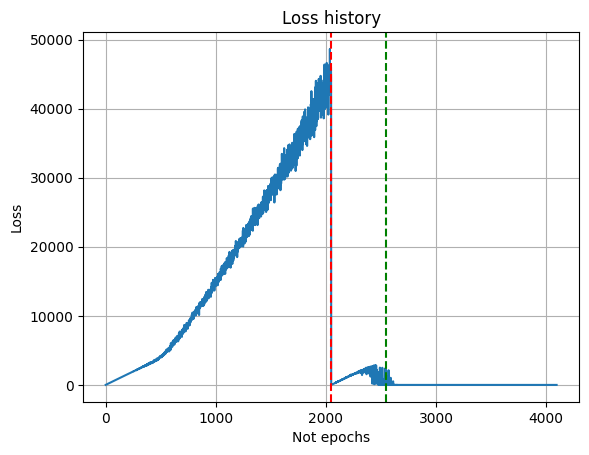

In [290]:
plt.plot(lhis[0])
plt.title("Loss history")
plt.xlabel("Not epochs")
plt.ylabel("Loss")
plt.axvline(x=2047, color="r", linestyle="--")
plt.axvline(x=2047 + 500, color="g", linestyle="--")
plt.grid(True)
plt.show()

In [245]:
def f(i, j):
    criterion = t.nn.CrossEntropyLoss()
    print(diagonal_output[j].shape)
    return criterion(diagonal_output[j].unsqueeze(0), t.tensor([i])).detach().item()

In [246]:
f(0, 0)

torch.Size([2048])


8.025492668151855

In [116]:
i, j = params.d_vocab, params.d_vocab

# Create meshgrid of indices
i_indices = t.arange(i).view(-1, 1).expand(-1, i)
j_indices = t.arange(j).view(1, -1).expand(j, -1)

# Apply the function to each pair of indices
result_tensor = t.stack(
    [f(i.item(), j.item()) for i, j in zip(i_indices.flatten(), j_indices.flatten())]
).reshape(i, j)

print(result_tensor)

KeyboardInterrupt: 

In [51]:
criterion = t.nn.CrossEntropyLoss()
loss_convex = 0


for i in range(params.d_vocab):
    print(i)
    for j in range(i):
        factor = 1 if i == j else 2
        loss_convex += factor * (
            criterion(diagonal_output[j].unsqueeze(0), t.tensor([i])).detach().item()
            + criterion(diagonal_output[i].unsqueeze(0), t.tensor([i])).detach().item()
        )

0
1


NameError: name 'diagonal_output' is not defined

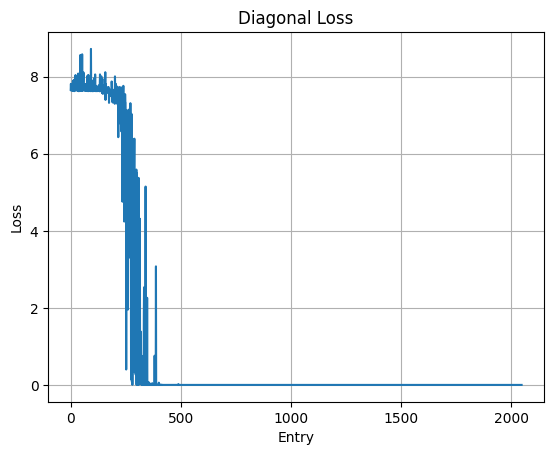

In [105]:
plt.plot(diagonal_loss)
plt.title("Diagonal Loss")
plt.xlabel("Entry")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [60]:
loss_estimate = 0

for i in range(params.d_vocab):
    for j in range(params.d_vocab):
        loss_estimate += max(diagonal_loss[i], diagonal_loss[j])

loss_convex = loss_estimate / params.d_vocab**2


print(loss_estimate)

8278952.19258868


In [61]:
performance_time.append((loss_convex, 1.6 + 0.7))

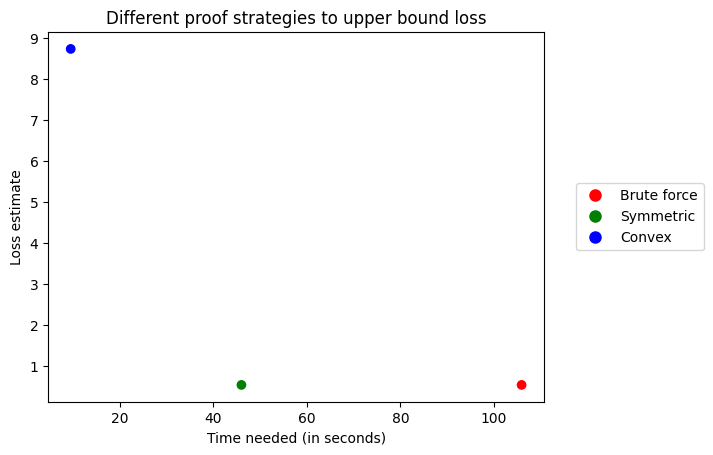

In [299]:
x = [performance_time[i][1] for i in range(3)]
y = [performance_time[i][0] for i in range(3)]
labels = ["Brute force", "Symmetric", "Convex"]
colors = ["red", "green", "blue"]


# Create plot
plt.scatter(x, y, c=colors)


for label, color in zip(labels, colors):
    plt.plot([], [], marker="o", linestyle="", markersize=8, color=color, label=label)

plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
plt.title("Different proof strategies to upper bound loss")
plt.xlabel("Time needed (in seconds)")
plt.ylabel("Loss estimate")
plt.show()

In [43]:
def convexity_proof(model, params):

    for x in range(0, params.d_vocab):
        print(x)
        x_tensor = t.tensor([x] * (params.d_vocab - x))
        y_tensor = t.tensor([x + i for i in range(params.d_vocab - x)])

        labels = t.max(x_tensor, y_tensor)
        inputs = t.stack(
            [
                F.one_hot(x_tensor, num_classes=params.d_vocab).float(),
                F.one_hot(y_tensor, num_classes=params.d_vocab).float(),
            ],
            dim=1,
        )

        outputs = model(inputs)

        predicted_label = t.argmax(outputs, dim=1)

        correct_predictions = labels == predicted_label
        count += correct_predictions.sum()

    return count / ((params.d_vocab**2 + params.d_vocab) * 0.5)

## 3. Making convex work for $n=3$

In [105]:
params_3 = Parameters(n_ctx=3, d_vocab=32)
train_data_3 = TrainingDataMax(params=params_3)

In [106]:
test_dataset(train_data_3)

Train data defined
Data loaded
Testing TrainingDataMax with 32768 samples...
Batch 1
tensor([ 2, 14, 18,  ..., 11, 22,  5])
tensor([23, 20, 27,  ..., 10, 11, 30])
tensor([ 1, 30, 24,  ..., 29, 27, 15])
tensor([23, 30, 27,  ..., 29, 27, 30])
Batch 2
tensor([29, 26,  0,  ..., 13, 30, 29])
tensor([14,  8, 18,  ..., 21, 24, 18])
tensor([10,  5, 19,  ...,  8,  3, 12])
tensor([29, 26, 19,  ..., 21, 30, 29])
Batch 3
tensor([ 8, 11, 19,  ..., 24, 16, 15])
tensor([ 5, 24, 23,  ..., 14,  9,  8])
tensor([13,  5,  4,  ...,  8, 31, 24])
tensor([13, 24, 23,  ..., 24, 31, 24])
Batch 4
tensor([ 4, 20, 24,  ...,  9, 15, 31])
tensor([16,  5,  4,  ..., 26,  8, 23])
tensor([ 3, 23,  7,  ..., 23, 19, 28])
tensor([16, 23, 24,  ..., 26, 19, 31])
Batch 5
tensor([28, 21,  1,  ..., 12, 16,  6])
tensor([12, 19, 28,  ...,  8, 14, 19])
tensor([15, 11, 19,  ..., 10,  2, 29])
tensor([28, 21, 28,  ..., 12, 16, 29])
Batch 6
tensor([17, 27,  3,  ..., 10,  0, 23])
tensor([ 4, 23,  4,  ...,  0, 27, 31])
tensor([ 1,  7,  

In [107]:
model_3 = MLP(params=params_3)

In [ ]:
test_model(model_3, dataset=train_data_3)

In [108]:
loss_history_3 = train(model=model_3, params=params_3)

Loading data...
Train data defined
Data loaded
0
1


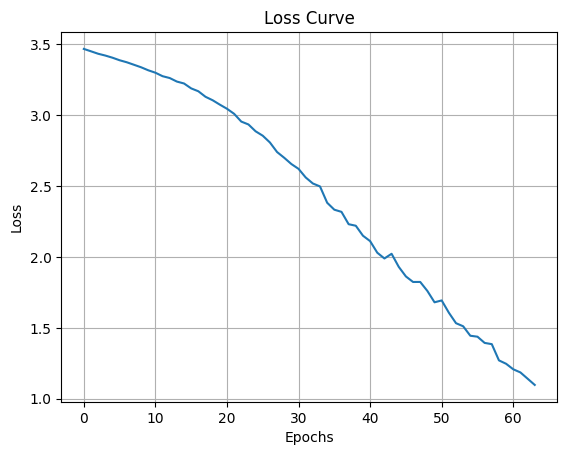

In [109]:
plt.plot(loss_history_3)
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [110]:
loss_history_3[-5:]

[1.2464648485183716,
 1.2075096368789673,
 1.185351848602295,
 1.1413304805755615,
 1.0971992015838623]

In [111]:
loss_exact = 0
loss_estimate = 0
n = params_3.d_vocab

criterion = t.nn.CrossEntropyLoss()
with t.no_grad():
    for x in tqdm(range(n)):
        for y in range(n):
            for z in range(n):
                input = [x, y, z]
                input.sort()
                a, b, c = input

                a_tensor = t.tensor([a])
                b_tensor = t.tensor([b])
                c_tensor = t.tensor([c])

                input_abc = t.stack(
                    [
                        F.one_hot(a_tensor, num_classes=params_3.d_vocab).float(),
                        F.one_hot(b_tensor, num_classes=params_3.d_vocab).float(),
                        F.one_hot(c_tensor, num_classes=params_3.d_vocab).float(),
                    ],
                    dim=1,
                )

                input_aac = t.stack(
                    [
                        F.one_hot(a_tensor, num_classes=params_3.d_vocab).float(),
                        F.one_hot(a_tensor, num_classes=params_3.d_vocab).float(),
                        F.one_hot(c_tensor, num_classes=params_3.d_vocab).float(),
                    ],
                    dim=1,
                )

                input_bbc = t.stack(
                    [
                        F.one_hot(b_tensor, num_classes=params_3.d_vocab).float(),
                        F.one_hot(b_tensor, num_classes=params_3.d_vocab).float(),
                        F.one_hot(c_tensor, num_classes=params_3.d_vocab).float(),
                    ],
                    dim=1,
                )

                if a == b or b == c:

                    outputs = model_3(input_abc)
                    loss_eq = criterion(outputs, c_tensor)
                    loss_exact += loss_eq
                    loss_estimate += loss_eq

                else:
                    outputs = model_3(input_abc)

                    loss = criterion(outputs, c_tensor)
                    loss_exact += loss

                    outputs_aac = model_3(input_aac)
                    outputs_bbc = model_3(input_bbc)

                    loss_aac = 0.5 * criterion(outputs_aac, c_tensor)
                    loss_bbc = 0.5 * criterion(outputs_bbc, c_tensor)

                    loss_estimate += loss_aac + loss_bbc

100%|██████████| 32/32 [00:14<00:00,  2.28it/s]


In [137]:
print(loss_estimate)
print(loss_exact)

tensor(42332.6641)
tensor(35329.0703)


In [131]:
@measure_time
def brute_force_loss_proof_3(model, params):
    loss = 0
    criterion = t.nn.CrossEntropyLoss(reduction="sum")

    count = 0

    with t.no_grad():
        model.eval()

        for x in tqdm(range(0, params.d_vocab)):

            x_tensor = t.tensor(
                [i for i in range(params.d_vocab) for _ in range(params.d_vocab)]
            )

            y_tensor = t.tensor(list(range(params.d_vocab)) * params.d_vocab)

            z_tensor = t.tensor([x] * params.d_vocab**2)

            max_xy = t.max(x_tensor, y_tensor)
            labels = t.max(max_xy, z_tensor)

            inputs = t.stack(
                [
                    F.one_hot(x_tensor, num_classes=params.d_vocab).float(),
                    F.one_hot(y_tensor, num_classes=params.d_vocab).float(),
                    F.one_hot(z_tensor, num_classes=params.d_vocab).float(),
                ],
                dim=1,
            )

            outputs = model(inputs)
            count += labels.size(0)
            loss += criterion(outputs, labels)

    return loss, count

In [132]:
x, y = brute_force_loss_proof_3(model=model_3, params=params_3)[0]

100%|██████████| 32/32 [00:00<00:00, 426.76it/s]

Function 'brute_force_loss_proof_3' executed in: 0.078843 seconds


In [134]:
print(x)
print(y)
print(loss_exact)

tensor(35329.3750)
32768
tensor(35329.0703)


In [87]:
def convexity_proof_three_equal(
    model,
    params: Parameters,
):

    loss = 0
    criterion = t.nn.CrossEntropyLoss(reduction="sum")

    with t.no_grad():

        # Estimate f(x,x,x)

        x_one_hot = t.eye(params.d_vocab)

        inputs = t.stack([x_one_hot] * 3, dim=1)
        outputs = model(inputs)

        loss += criterion(outputs, t.tensor([i for i in range(params.d_vocab)]))

    return loss

In [88]:
def convexity_proof_two_equal(model, params: Parameters):

    loss = 0
    criterion = t.nn.CrossEntropyLoss(reduction="sum")

    with t.no_grad():
        # Estimate f(x,x,z) where x<z
        for z in range(1, params.d_vocab):

            # [0,1,...,z-1]
            x_tensor = t.tensor([i for i in range(z)])
            # [z,z,...,z]
            z_tensor = t.tensor([z] * z)

            inputs = t.stack(
                [
                    F.one_hot(x_tensor, num_classes=params.d_vocab).float(),
                    F.one_hot(x_tensor, num_classes=params.d_vocab).float(),
                    F.one_hot(z_tensor, num_classes=params.d_vocab).float(),
                ],
                dim=1,
            )
            outputs = model(inputs)

            loss += 3 * criterion(outputs, z_tensor)

        # Estimate f(x,z,z) where x<z
        for z in range(1, params.d_vocab):

            # [0,1,...,z-1]
            x_tensor = t.tensor([i for i in range(z)])
            # [z,z,...,z]
            z_tensor = t.tensor([z] * z)

            inputs = t.stack(
                [
                    F.one_hot(x_tensor, num_classes=params.d_vocab).float(),
                    F.one_hot(z_tensor, num_classes=params.d_vocab).float(),
                    F.one_hot(z_tensor, num_classes=params.d_vocab).float(),
                ],
                dim=1,
            )
            outputs = model(inputs)

            loss += 3 * criterion(outputs, z_tensor)

    return loss

In [141]:
def convexity_proof(model, params: Parameters):

    loss = []
    criterion = t.nn.CrossEntropyLoss(reduction="sum")

    with t.no_grad():
        # Estimate f(x,y,z) where x<y<z

        def estimate_fixed(z: int):
            count = 0

            # [0,1,...,z-1]
            x_tensor = t.tensor([i for i in range(z)])

            length = x_tensor.size(dim=0)

            # [z,z,...,z]
            z_tensor = t.tensor([z] * length)

            inputs = t.stack(
                [
                    F.one_hot(x_tensor, num_classes=params.d_vocab).float(),
                    F.one_hot(x_tensor, num_classes=params.d_vocab).float(),
                    F.one_hot(z_tensor, num_classes=params.d_vocab).float(),
                ],
                dim=1,
            )

            outputs = model(inputs)

            count = (length - 1) * criterion(outputs, z_tensor)
            # This should be 3
            return 6 * count

        for z in tqdm(range(2, params.d_vocab)):
            loss.append(estimate_fixed(z))

    loss.append(convexity_proof_three_equal(model=model, params=params))

    loss.append(convexity_proof_two_equal(model=model, params=params))

    return loss

In [142]:
x = convexity_proof(model=model_3, params=params_3)

100%|██████████| 30/30 [00:00<00:00, 892.85it/s]


In [144]:
print(sum(x))
print(loss_estimate)

tensor(42332.8164)
tensor(42332.6641)


In [ ]:
history_estimate = []
history_exact = []
n = 240
b = 220
with t.no_grad():

    x_tensor = t.tensor([b] * n)
    y_tensor = t.tensor([i for i in range(n)])
    z_tensor = t.tensor([n] * n)

    inputs = t.stack(
        [
            F.one_hot(x_tensor, num_classes=params_3.d_vocab).float(),
            F.one_hot(y_tensor, num_classes=params_3.d_vocab).float(),
            F.one_hot(z_tensor, num_classes=params_3.d_vocab).float(),
        ],
        dim=1,
    )
    outputs = model_3(inputs)

    history_exact.append(t.nn.CrossEntropyLoss(reduction="mean")(outputs, z_tensor))

    inputs = t.stack(
        [
            F.one_hot(x_tensor, num_classes=params_3.d_vocab).float(),
            F.one_hot(x_tensor, num_classes=params_3.d_vocab).float(),
            F.one_hot(z_tensor, num_classes=params_3.d_vocab).float(),
        ],
        dim=1,
    )
    outputs = model_3(inputs)

    history_estimate.append(
        0.5 * t.nn.CrossEntropyLoss(reduction="mean")(outputs, z_tensor)
    )

    inputs = t.stack(
        [
            F.one_hot(y_tensor, num_classes=params_3.d_vocab).float(),
            F.one_hot(y_tensor, num_classes=params_3.d_vocab).float(),
            F.one_hot(z_tensor, num_classes=params_3.d_vocab).float(),
        ],
        dim=1,
    )
    outputs = model_3(inputs)
    history_estimate.append(
        0.5 * t.nn.CrossEntropyLoss(reduction="mean")(outputs, z_tensor)
    )

In [275]:
history = []
n = 255
with t.no_grad():
    for x in range(n):

        x_tensor = t.tensor([x])
        z_tensor = t.tensor([n])

        inputs = t.stack(
            [
                F.one_hot(x_tensor, num_classes=params_3.d_vocab).float(),
                F.one_hot(x_tensor, num_classes=params_3.d_vocab).float(),
                F.one_hot(z_tensor, num_classes=params_3.d_vocab).float(),
            ],
            dim=1,
        )
        outputs = model_3(inputs)

        history.append(t.nn.CrossEntropyLoss(reduction="sum")(outputs, z_tensor))

In [264]:
history_estimate

[tensor(4.5987), tensor(1.1078)]

In [265]:
print(history_exact)
print(sum(history_estimate))

[tensor(0.1677)]
tensor(5.7065)


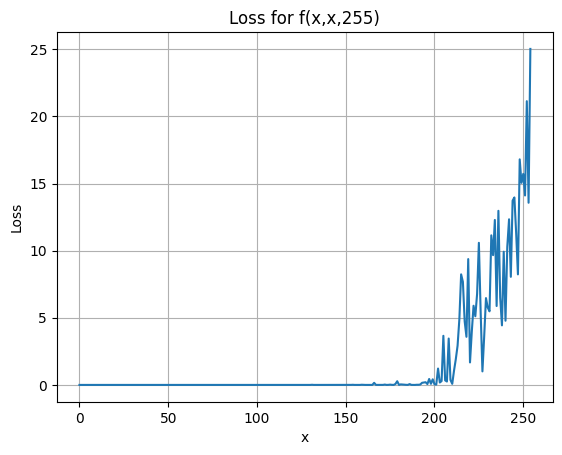

In [276]:
plt.plot(history)
plt.title(f"Loss for f(x,x,{n})")
plt.xlabel("x")
plt.ylabel("Loss")

plt.grid(True)
plt.show()

## Comparing losses

In [66]:
params_compare = Parameters(batch_size=2048, subset_percentage=5, num_epoch=4)

In [67]:
model_baseline = MLP(params=params_compare)
model_convex = copy.deepcopy(model_baseline)

In [68]:
loss_baseline = train(model=model_baseline, params=params_compare)

Loading data...
Train data defined
Data loaded
0
2048
4096
6144
8192
10240
12288
14336
16384
18432
20480
22528
24576
26624
28672
30720
32768
34816
36864
38912
40960
43008
45056
47104
49152
51200
53248
55296
57344
59392
61440
63488
65536
67584
69632
71680
73728
75776
77824
79872
81920
83968
86016
88064
90112
92160
94208
96256
98304
100352
102400
104448
106496
108544
110592
112640
114688
116736
118784
120832
122880
124928
126976
129024
131072
133120
135168
137216
139264
141312
143360
145408
147456
149504
151552
153600
155648
157696
159744
161792
163840
165888
167936
169984
172032
174080
176128
178176
180224
182272
184320
186368
188416
190464
192512
194560
196608
198656
200704
202752
204800
206848
208896
0
2048
4096
6144
8192
10240
12288
14336
16384
18432
20480
22528
24576
26624
28672
30720
32768
34816
36864
38912
40960
43008
45056
47104
49152
51200
53248
55296
57344
59392
61440
63488
65536
67584
69632
71680
73728
75776
77824
79872
81920
83968
86016
88064
90112
92160
94208
96256
98304
100

In [69]:
len(loss_baseline)

412

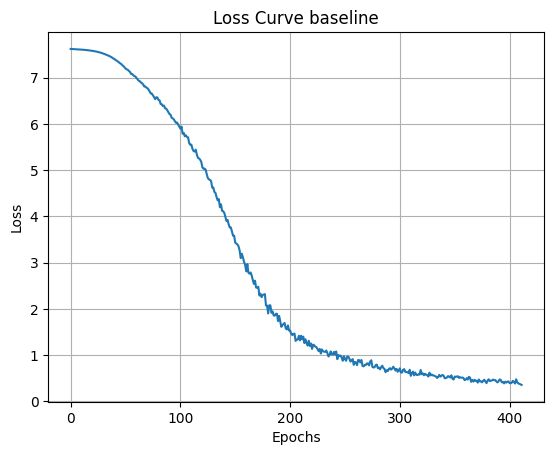

In [70]:
plt.plot(loss_baseline)
plt.title("Loss Curve baseline")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [76]:
symmetry_proof_loss(model=model_baseline, params=params)

0.0
0.0004885197850512946
0.0009770395701025891
0.0014655593551538837
0.0019540791402051783
0.002442598925256473
0.0029311187103077674
0.003419638495359062
0.0039081582804103565
0.004396678065461651
0.004885197850512946
0.00537371763556424
0.005862237420615535
0.006350757205666829
0.006839276990718124
0.0073277967757694185
0.007816316560820713
0.008304836345872008
0.008793356130923302
0.009281875915974597
0.009770395701025891
0.010258915486077186
0.01074743527112848
0.011235955056179775
0.01172447484123107
0.012212994626282364
0.012701514411333659
0.013190034196384953
0.013678553981436248
0.014167073766487542
0.014655593551538837
0.015144113336590131
0.015632633121641426
0.01612115290669272
0.016609672691744015
0.01709819247679531
0.017586712261846604
0.0180752320468979
0.018563751831949193
0.019052271617000488
0.019540791402051783
0.020029311187103077
0.02051783097215437
0.021006350757205666
0.02149487054225696
0.021983390327308255
0.02247191011235955
0.022960429897410845
0.0234489496

(tensor(0.3897), 55.609352111816406)

In [78]:
symmetry_proof_loss(model=model_convex, params=params)

0.0
0.0004885197850512946
0.0009770395701025891
0.0014655593551538837
0.0019540791402051783
0.002442598925256473
0.0029311187103077674
0.003419638495359062
0.0039081582804103565
0.004396678065461651
0.004885197850512946
0.00537371763556424
0.005862237420615535
0.006350757205666829
0.006839276990718124
0.0073277967757694185
0.007816316560820713
0.008304836345872008
0.008793356130923302
0.009281875915974597
0.009770395701025891
0.010258915486077186
0.01074743527112848
0.011235955056179775
0.01172447484123107
0.012212994626282364
0.012701514411333659
0.013190034196384953
0.013678553981436248
0.014167073766487542
0.014655593551538837
0.015144113336590131
0.015632633121641426
0.01612115290669272
0.016609672691744015
0.01709819247679531
0.017586712261846604
0.0180752320468979
0.018563751831949193
0.019052271617000488
0.019540791402051783
0.020029311187103077
0.02051783097215437
0.021006350757205666
0.02149487054225696
0.021983390327308255
0.02247191011235955
0.022960429897410845
0.0234489496

(tensor(1.6552), 67.38567185401917)

In [ ]:
symmetry_proof_accuracy(model=model_baseline, params=params_compare)

## Implementing the cubic proof

In [238]:
def symmetry_proof(model, params: Parameters):

    loss = 0
    criterion = t.nn.CrossEntropyLoss(reduction="sum")

    with t.no_grad():
        # Estimate f(x,y,z) where x<y<z

        def symmetry_fixed(z: int):
            count = 0

            # [1,2,2,3,3,3,...]
            y_tensor = t.tensor([i for i in range(1, z) for _ in range(i)])
            # [0,0,1,0,1,2,...]
            x_tensor = t.tensor([j for i in range(z - 1) for j in range(i + 1)])

            length = y_tensor.size(dim=0)

            z_tensor = t.tensor([z] * length)

            inputs = t.stack(
                [
                    F.one_hot(x_tensor, num_classes=params.d_vocab).float(),
                    F.one_hot(y_tensor, num_classes=params.d_vocab).float(),
                    F.one_hot(z_tensor, num_classes=params.d_vocab).float(),
                ],
                dim=1,
            )

            outputs = model(inputs)

            count = criterion(outputs, z_tensor)

            return 6 * count

        for z in tqdm(range(2, params.d_vocab)):
            loss += symmetry_fixed(z)

    loss += convexity_proof_three_equal(model=model, params=params)

    loss += convexity_proof_two_equal(model=model, params=params)

    return loss

In [31]:
random_1 = t.tensor([2, 1, 1, 1]).float()
random_2 = t.tensor([2, 2, 2, 2]).float()

In [ ]:
f = t.nn.Softmax()

e1 = t.log(random_1)
e2 = t.log(random_2)
print(f(random_1))
print(f(random_2))

tensor([0.4754, 0.1749, 0.1749, 0.1749])
tensor([0.2500, 0.2500, 0.2500, 0.2500])
